In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as SNS
import plotly.graph_objs as go
%matplotlib inline

In [3]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import itertools
from prophet.diagnostics import performance_metrics, cross_validation
from sklearn.metrics import mean_squared_error

In [4]:
daily = pd.read_csv('prophetdf.csv')

In [5]:
#create train and test sets for one month period
train = daily[:-30]
test = daily[-30:]

02:09:25 - cmdstanpy - INFO - Chain [1] start processing
02:09:25 - cmdstanpy - INFO - Chain [1] done processing


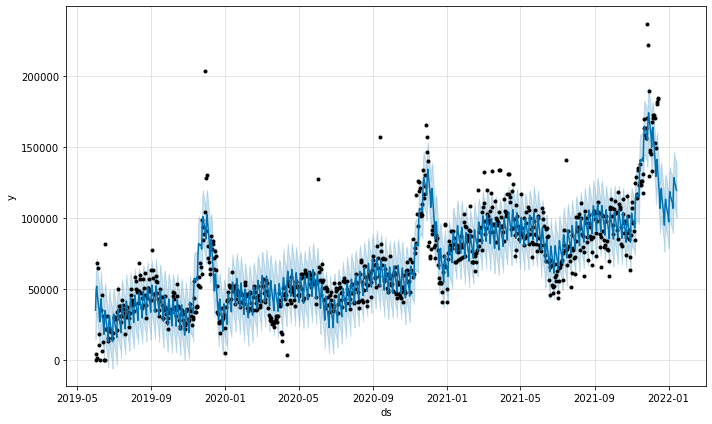

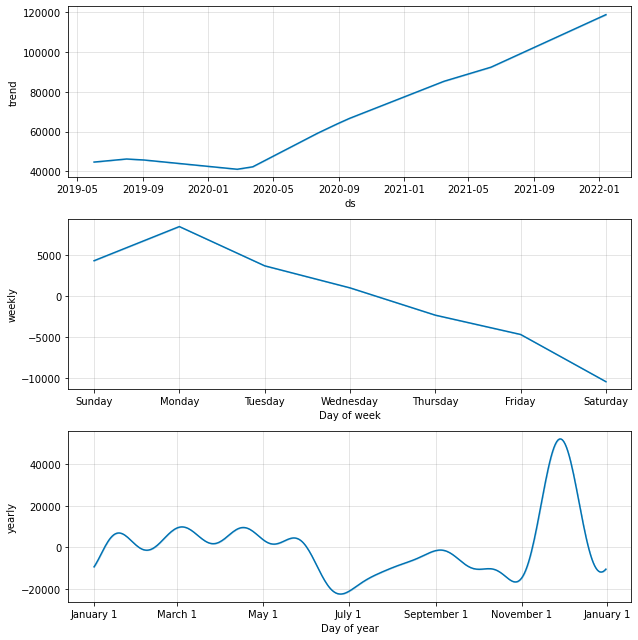

In [8]:
#baseline model

m = Prophet()
m.fit(train)
future = pd.DataFrame()
future['ds'] = daily['ds']
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [10]:
y_pred = forecast['yhat'][-30:]
y_test = test['y']
np.sqrt(mean_squared_error(y_test, y_pred))

31376.50024214348

In [11]:
#create holiday for new years eve
nye = pd.DataFrame({
  'holiday': 'nye',
  'ds': pd.to_datetime(['2019-12-31', '2020-12-31','2021-12-31','2022-12-31']),
  'lower_window': 0,
  'upper_window': 0,
})
#create holiday for initial covid lockdown
covid_lockdown = pd.DataFrame({
  'holiday': 'covid_lockdown',
  'ds': pd.date_range('2020-03-12','2020-04-13'),
  'lower_window': 0,
  'upper_window': 0,
})
#combine holiday dataframes
holidays = pd.concat((nye, covid_lockdown))

In [32]:
#remove outliers
daily_cl = daily.drop(index=[366,468,774,314,957]) #180, 213
daily_cl = daily_cl[30:]
daily_cl['ds']=  pd.to_datetime(daily_cl['ds'])
daily_cl = daily_cl.reset_index(drop=True)
train_cl = daily_cl[:-30]
test_cl = daily_cl[-30:]

03:00:46 - cmdstanpy - INFO - Chain [1] start processing
03:00:46 - cmdstanpy - INFO - Chain [1] done processing


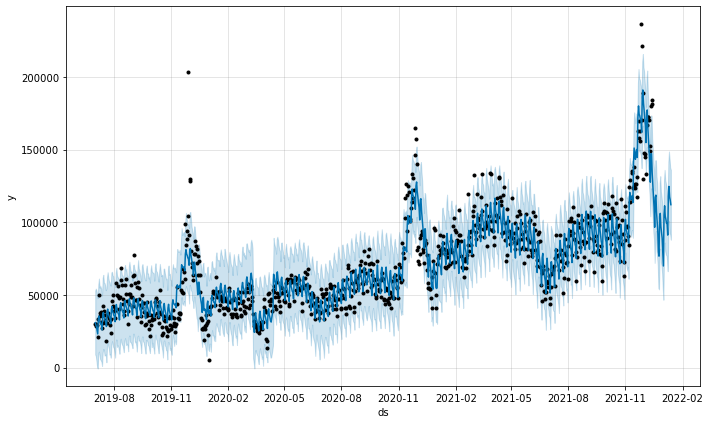

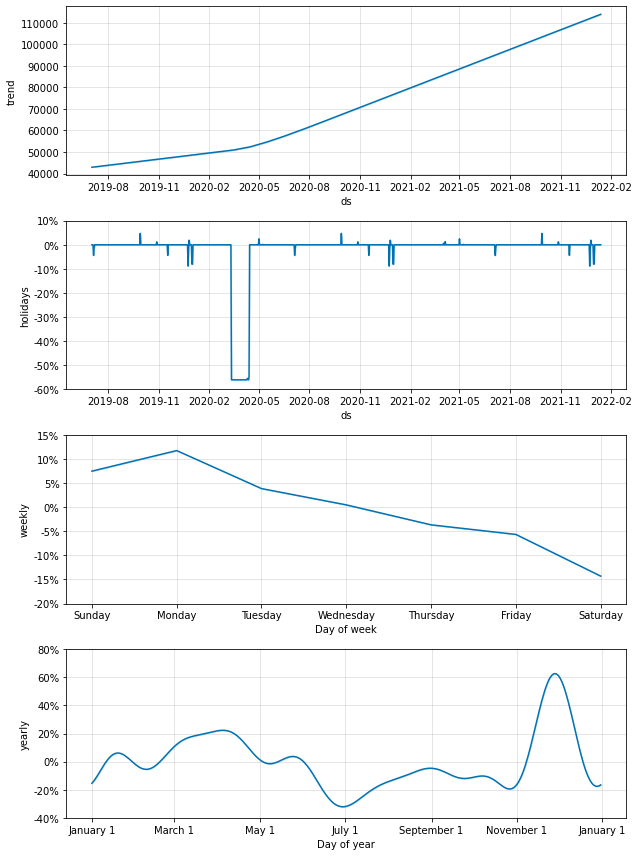

In [44]:
#prophet model with holidays and gridsearched parameters
m = Prophet(holidays = holidays, interval_width=0.95, changepoint_prior_scale=.01, holidays_prior_scale = 0.75, seasonality_prior_scale=0.05, seasonality_mode = "multiplicative") 
#{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.025, 'holidays_prior_scale': 0.75}
m.add_country_holidays(country_name='CZ')
#m.add_regressor('stringency_index')
m.fit(train_cl)
future = pd.DataFrame()
future['ds'] = daily_cl['ds']
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [45]:
y_pred = forecast['yhat'][-30:]
y_test = test_cl['y']
np.sqrt(mean_squared_error(y_test, y_pred))

18349.754764836747

In [35]:
# parameter grid for grid search
param_grid = {
    'changepoint_prior_scale': [0.0075, 0.01, 0.025],
    'seasonality_prior_scale': [0.025, 0.05, 0.075, 0.1, 0.5,],
    'holidays_prior_scale': [0.25, 0.5, 0.75, 1],
    #'seasonality_mode': ['additive', 'multiplicative']
}
#'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Use cross validation to evaluate all parameters
rmses = [] 
for params in all_params:
    m = Prophet(**params, holidays=holidays, seasonality_mode ='multiplicative')
    m.add_country_holidays(country_name='CZ')
    m.fit(daily_cl)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
best_params = all_params[np.argmin(rmses)]
print(best_params)

02:34:40 - cmdstanpy - INFO - Chain [1] start processing
02:34:40 - cmdstanpy - INFO - Chain [1] done processing
02:34:58 - cmdstanpy - INFO - Chain [1] start processing
02:34:58 - cmdstanpy - INFO - Chain [1] done processing
02:35:15 - cmdstanpy - INFO - Chain [1] start processing
02:35:15 - cmdstanpy - INFO - Chain [1] done processing
02:35:34 - cmdstanpy - INFO - Chain [1] start processing
02:35:34 - cmdstanpy - INFO - Chain [1] done processing
02:35:53 - cmdstanpy - INFO - Chain [1] start processing
02:35:53 - cmdstanpy - INFO - Chain [1] done processing
02:36:10 - cmdstanpy - INFO - Chain [1] start processing
02:36:10 - cmdstanpy - INFO - Chain [1] done processing
02:36:28 - cmdstanpy - INFO - Chain [1] start processing
02:36:28 - cmdstanpy - INFO - Chain [1] done processing
02:36:43 - cmdstanpy - INFO - Chain [1] start processing
02:36:43 - cmdstanpy - INFO - Chain [1] done processing
02:36:58 - cmdstanpy - INFO - Chain [1] start processing
02:36:58 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.025, 'holidays_prior_scale': 0.75}


In [19]:
weekly = pd.read_csv('weekly_prophetdf.csv')

In [26]:
wtrain = weekly[:-5]
wtest = weekly[-5:]

02:24:52 - cmdstanpy - INFO - Chain [1] start processing
02:24:52 - cmdstanpy - INFO - Chain [1] done processing


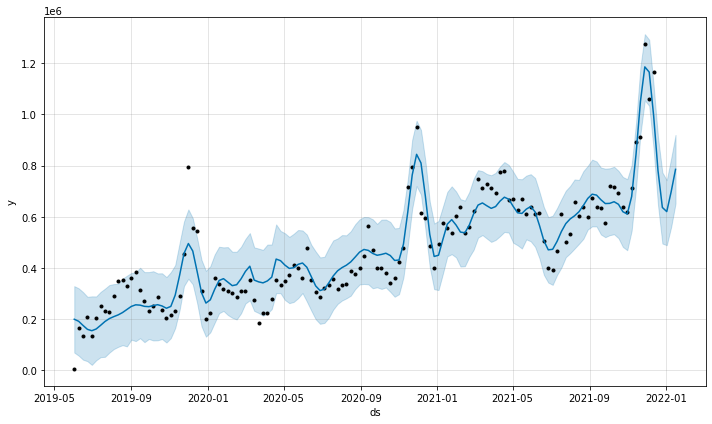

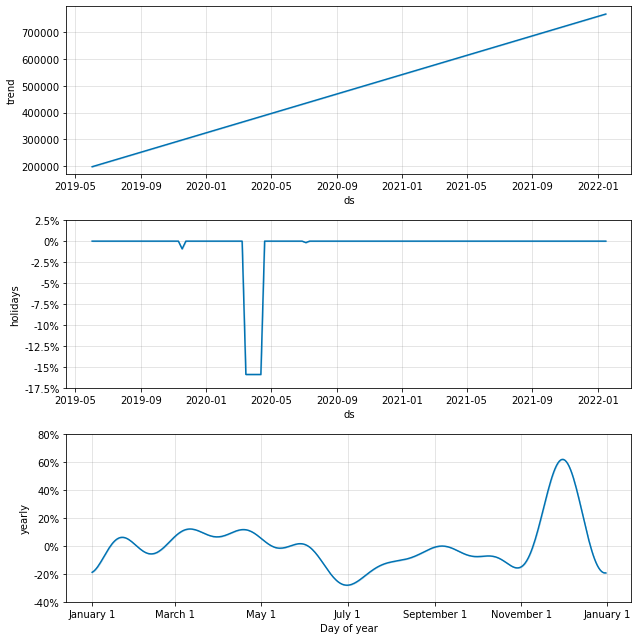

In [28]:
#baseline model

m = Prophet(holidays = holidays, interval_width=0.95, changepoint_prior_scale=.01, holidays_prior_scale = 0.5, seasonality_prior_scale=0.05, seasonality_mode = "multiplicative") 
m.add_country_holidays(country_name='CZ')
m.fit(wtrain)
future = pd.DataFrame()
future['ds'] = weekly['ds']
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [23]:
wtrain

,Unnamed: 0,ds,y
0,0,2019-06-01,4087.236534
1,1,2019-06-02,65.848327
2,2,2019-06-03,1364.979529
3,3,2019-06-04,68385.521621
4,4,2019-06-05,65135.657001
...,...,...,...
945,945,2022-01-02,93466.279742
946,946,2022-01-03,102294.937063
947,947,2022-01-04,98104.353685
948,948,2022-01-05,104320.580030
